Energy Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from common.utils import load_data

In [6]:
data_dir = 'C:\\Users\\Bam\\Desktop\\Disertatie\\halfhourly_dataset'
energy = load_data(data_dir)[['load']]
energy.tail()

,load
2014-02-27 22:00:00,0.416
2014-02-27 22:30:00,1.35
2014-02-27 23:00:00,1.247
2014-02-27 23:30:00,1.2180001
2014-02-28 00:00:00,1.387


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24192 entries, 2012-10-12 00:30:00 to 2014-02-28 00:00:00
Freq: 30T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    24140 non-null  float64
dtypes: float64(1)
memory usage: 378.0 KB
DataFrame info:
 None
Non-numeric values in 'load' turned into NaN:
                      load
2012-10-12 11:00:00   NaN
2012-11-02 19:30:00   NaN
2012-11-08 00:30:00   NaN
2012-11-08 01:00:00   NaN
2012-11-08 01:30:00   NaN
2012-11-08 02:00:00   NaN
2012-11-08 02:30:00   NaN
2012-11-08 03:00:00   NaN
2012-11-08 03:30:00   NaN
2012-11-08 04:00:00   NaN
2012-11-08 04:30:00   NaN
2012-11-08 05:00:00   NaN
2012-11-08 05:30:00   NaN
2012-11-08 06:00:00   NaN
2012-11-08 06:30:00   NaN
2012-11-08 07:00:00   NaN
2012-11-08 07:30:00   NaN
2012-11-08 08:00:00   NaN
2012-11-08 08:30:00   NaN
2012-11-08 09:00:00   NaN
2012-11-08 09:30:00   NaN
2012-11-08 10:00:00   NaN
2012-11-08 10:30:00   NaN
2

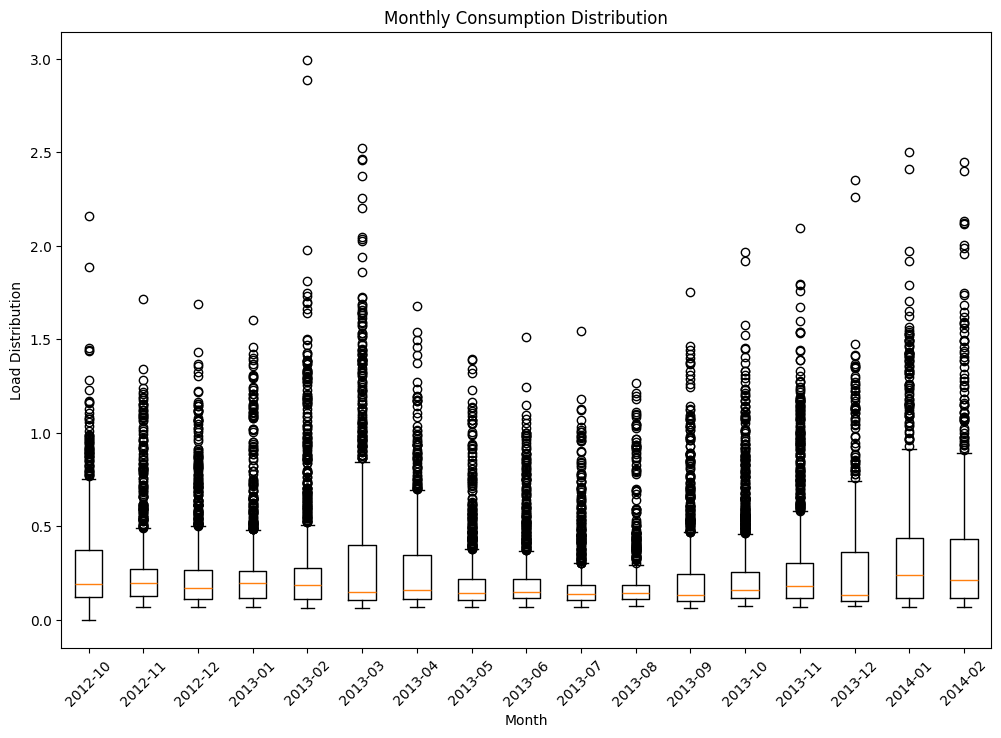

In [13]:

# Ensure the load column is of numeric type
energy['load'] = pd.to_numeric(energy['load'], errors='coerce')

# Verify the data types
print("DataFrame info:\n", energy.info())

# Check for any non-numeric values turned into NaN
print("Non-numeric values in 'load' turned into NaN:\n", energy[energy['load'].isna()])

# Group data by month and extract the load values as lists
monthly_data = energy['load'].resample('M').apply(list)

# Ensure the grouped data is a list of lists
monthly_data_list = [list(filter(pd.notna, x)) for x in monthly_data]

# Check the structure of the monthly data
print("Monthly data list:\n", monthly_data_list)

# Plotting the monthly consumption distribution using a box plot
plt.figure(figsize=(12, 8))
plt.boxplot(monthly_data_list, labels=monthly_data.index.strftime('%Y-%m'))
plt.title('Monthly Consumption Distribution')
plt.xlabel('Month')
plt.ylabel('Load Distribution')
plt.xticks(rotation=45)
plt.show()

Reduce dataframe to a month worth of data

In [26]:
start_date = '2013-12-01 00:00:00'
end_date = '2014-01-01 00:00:00'

energy = energy.loc[start_date:end_date]
energy.head()

,load
2013-01-01 00:00:00,0.219
2013-01-01 00:30:00,0.241
2013-01-01 01:00:00,0.191
2013-01-01 01:30:00,0.235
2013-01-01 02:00:00,0.182


TypeError: no numeric data to plot

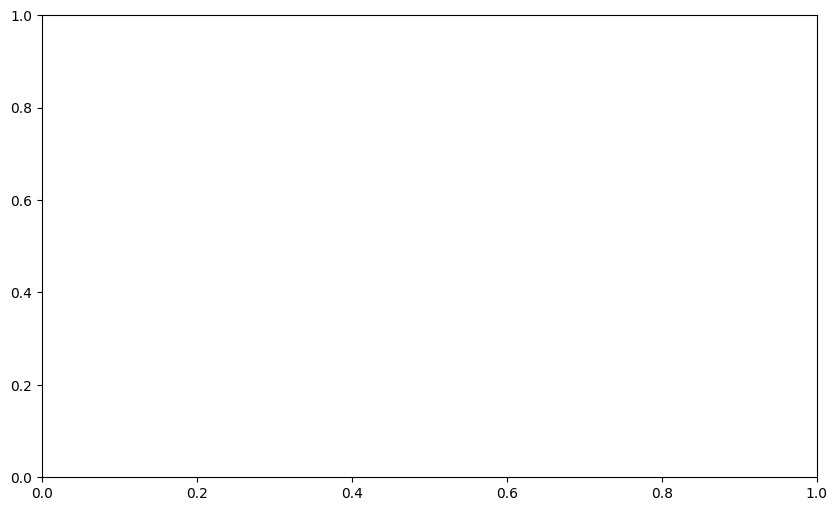

In [28]:
energy['timestamp'] = pd.to_datetime(energy.index)
energy.set_index('timestamp', inplace=True)


The train / test split data ratio is 80% / 20%

In [10]:
train_start_date = '2013-12-01 00:00:00'
test_start_date = '2013-12-25 19:00:00'

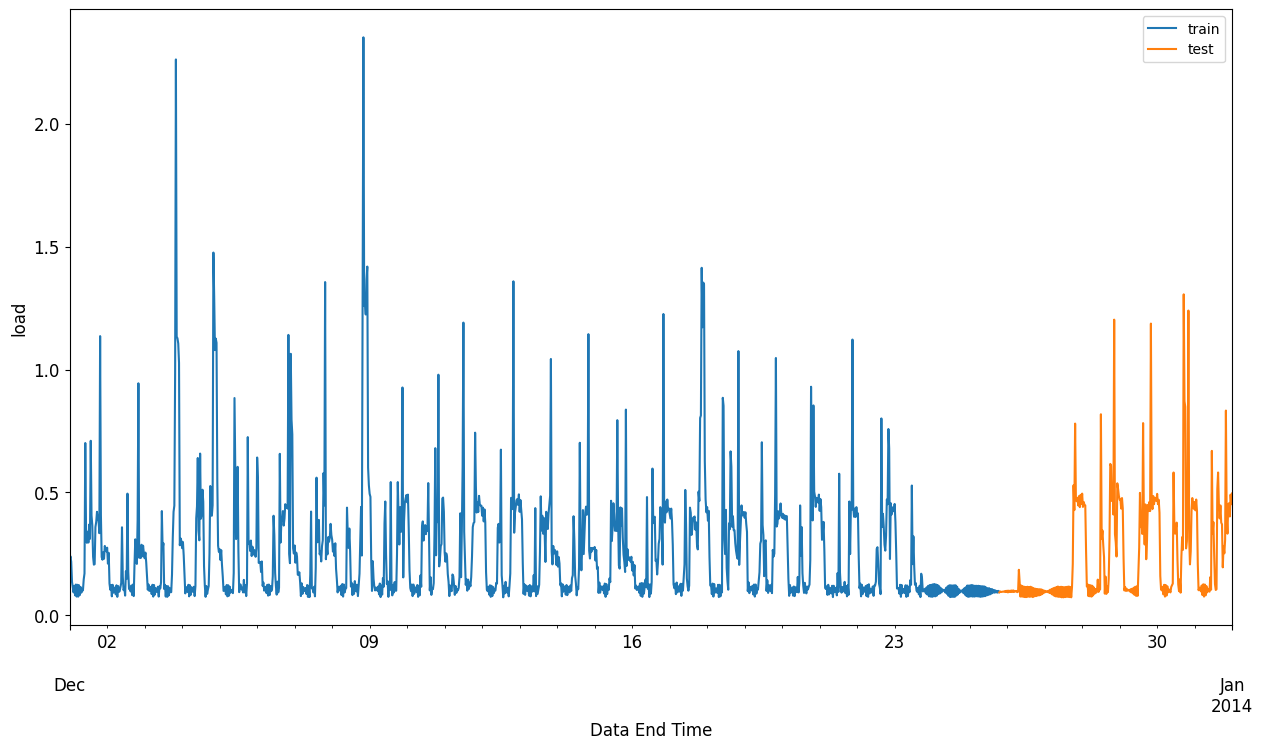

In [11]:
energy['load'] = pd.to_numeric(energy['load'])
energy[energy.index < test_start_date][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_date:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Data End Time', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Load weather data from different source into Pandas Dataframe

In [12]:
weather = pd.read_csv('C:\\Users\\Bam\\Desktop\\Disertatie\\london_weather_2013.csv')

weather['date'] = pd.to_datetime(weather['date'], format='%m/%d/%Y %H:%M')

weather.tail(2900)

                     date  wind_speed  pressure  temperature  \
14620 2013-11-01 14:00:00         4.0      1006         13.3   
14621 2013-11-01 14:30:00         3.8      1005         13.0   
14622 2013-11-01 15:00:00         3.6      1005         12.7   
14623 2013-11-01 15:30:00         3.2      1005         12.3   
14624 2013-11-01 16:00:00         2.8      1004         11.8   
...                   ...         ...       ...          ...   
17515 2013-12-31 21:30:00         3.7      1001          4.7   
17516 2013-12-31 22:00:00         3.9      1001          4.8   
17517 2013-12-31 22:30:00         4.0      1001          5.0   
17518 2013-12-31 23:00:00         4.2      1000          5.2   
17519 2013-12-31 23:30:00         4.4      1000          5.4   

       relative_humidity  precipitable_water  dew_point  
14620              88.10                 2.3       11.4  
14621              89.74                 2.2       11.4  
14622              91.14                 2.2       11.3  

Energy and Weather dataset integration and interpolation.

In [13]:
weather.set_index('date', inplace=True)

weather_energy = energy.merge(weather, how='left', left_index=True, right_index=True)

weather_energy.interpolate(method='time', inplace=True)

weather_energy.head()

,load,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
2013-12-01 00:00:00,0.222,1.9,1029.0,1.6,100.00,1.4,1.6
2013-12-01 00:30:00,0.240,2.0,1029.0,1.6,100.00,1.4,1.6
2013-12-01 01:00:00,0.218,2.0,1029.0,1.6,99.25,1.3,1.5
2013-12-01 01:30:00,0.136,2.1,1029.0,1.7,98.54,1.3,1.5
2013-12-01 02:00:00,0.115,2.3,1029.0,1.8,97.11,1.3,1.4


Feature Engineering

In [14]:
energy['load'] = pd.to_numeric(energy['load'], errors='coerce')
peak_threshold = energy['load'].quantile(0.90)  # Adjust the quantile as needed

bank_holidays = pd.read_csv('C:\\Users\\Bam\\Desktop\\Disertatie\\uk_bank_holidays.csv')
bank_holidays['Bank holidays'] = pd.to_datetime(bank_holidays['Bank holidays']).dt.date
bank_holiday_dates = set(bank_holidays['Bank holidays'])

weather_energy['temp_humidity_interaction'] = weather_energy['temperature'] * weather_energy['relative_humidity']

weather_energy['hour'] = energy.index.hour
weather_energy['day_of_week'] = energy.index.dayofweek
weather_energy['month'] = energy.index.month
weather_energy['is_weekend'] = energy.index.dayofweek >= 5
weather_energy['is_peak_hour'] = np.where(energy['load'] >= peak_threshold, 1, 0)
weather_energy['is_bank_holiday'] = pd.Series(weather_energy.index.date).isin(bank_holiday_dates).values

# Lag features
weather_energy['previous_load'] = energy['load'].shift(1).fillna(0)
weather_energy['previous_is_peak_hour'] = weather_energy['is_peak_hour'].shift(1).fillna(0)
weather_energy['lag_3'] = energy['load'].shift(3).fillna(0)
weather_energy['rolling_mean_3'] = energy['load'].rolling(window=3).mean().fillna(0)
weather_energy['rolling_mean_2'] = energy['load'].rolling(window=2).mean().fillna(0)

Splitting the data into training and testing sets

In [15]:
train = weather_energy[(weather_energy.index >= train_start_date) & (weather_energy.index <= test_start_date)]
test = weather_energy[(weather_energy.index >= test_start_date)]

X_train = train.drop(columns=['load'])
y_train = train['load']

X_test = test.drop(columns=['load'])
y_test = test['load']

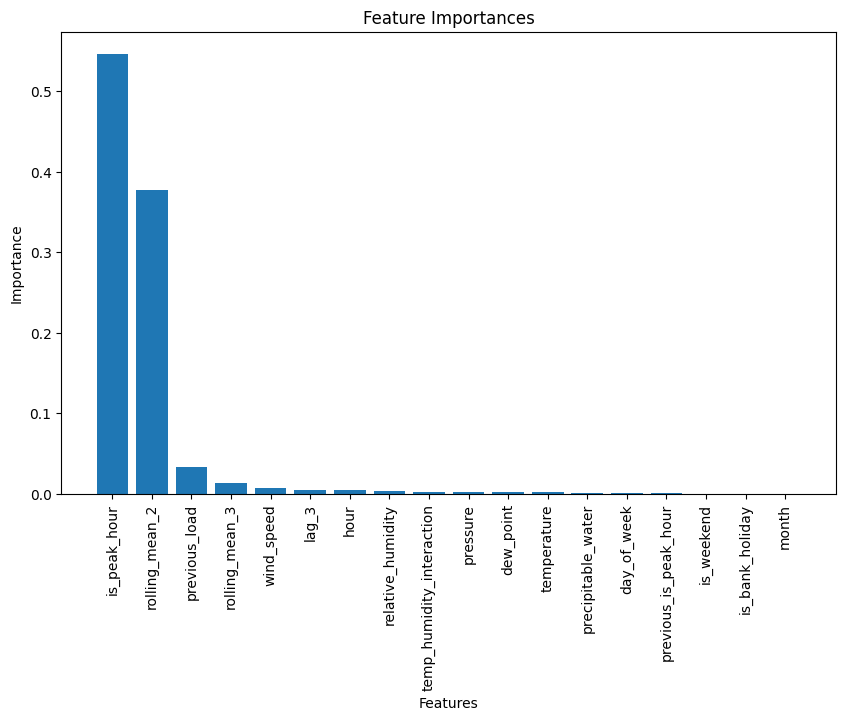

In [16]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming 'X' contains your feature matrix and 'y' contains your target variable
# X should be your weather_energy dataframe without the target variable
# y should be the target variable you are trying to predict

# Initialize Random Forest Regressor
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


Building, Training and Using the Model

In [17]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_regression)),
    ('svr', SVR())
])

# Define the parameter grid
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],  # Different scalers to try
    'selector__k': [1, 3, 6],  # Number of features to select
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__C': [0.1, 0.5, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.5, 0.9]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Predict energy consumption on the test set
y_pred = best_model.predict(X_test)

In [18]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Cross-validated MSE: {-np.mean(cv_scores)}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print('MAPE for testing data: ', mape * 100, '%')

Cross-validated MSE: 7.817274340154115e-05
Mean Squared Error: 2.8062001057191064e-05
R-squared: 0.9993802521266955
MAPE for testing data:  2.328165253416583 %


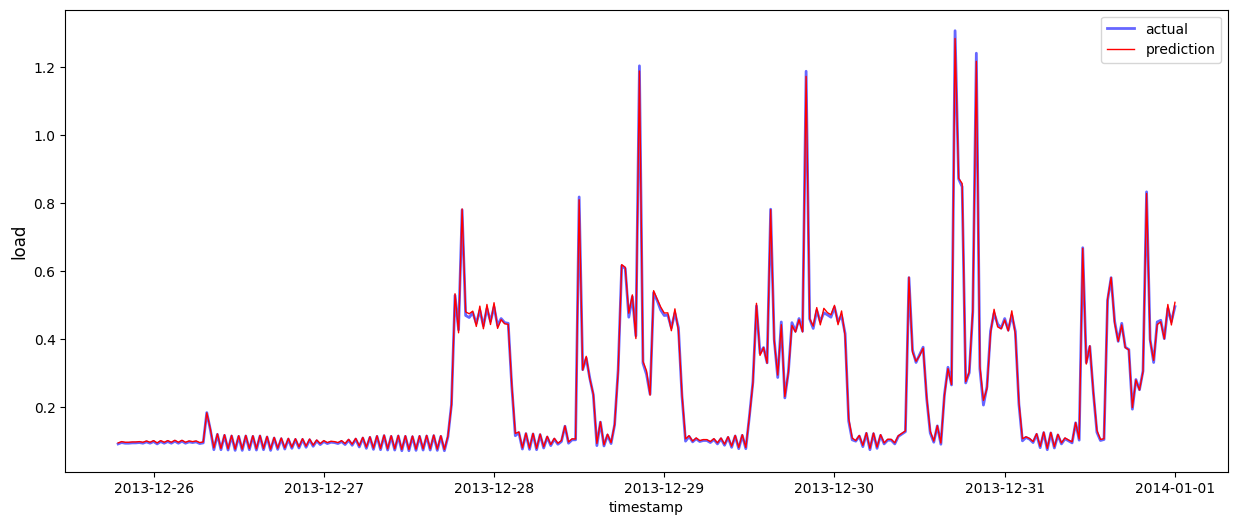

In [19]:
plt.figure(figsize=(15,6))
plt.plot(test.index, y_test, color = 'blue', linewidth=2.0, alpha = 0.6)
plt.plot(test.index, y_pred, color = 'red', linewidth=1.0)
plt.legend(['actual','prediction'])
plt.xlabel('timestamp')
plt.ylabel('load', fontsize=12)
plt.show()